<a href="https://colab.research.google.com/github/kumarmayank29/Face-Mask-Detection-Beep-Alert/blob/main/Covid_19_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

#cd content/Drive/My Drive/My_Projects/FACE_MASK_DETECTION

In [ ]:

import cv2,os
data_path='/content/drive/My Drive/My_Projects/FACE_MASK_DETECTION/Dataset/'


#Here I use listdir function from os package to list the Directories contained inside Dataset Folder thats why it shows
#two sub-directories with_mask and without_mask alongwith the labels which are zipped in a dictionary
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'with_mask': 0, 'without_mask': 1}
['with_mask', 'without_mask']
[0, 1]


Now we use nested for loop .First for loop picking up each class directory namely 1)with_mask and 2)without_mask from google drive location called as data_path .

It containes location of Dataset folder that is
/content/drive/My Drive/My_Projects/FACE_MASK_DETECTION/Dataset

Dataset which is shown above .Now Join Dataset folders with each individual with_mask and without_mask using seperator slash.We are using os.path.join method for this purpose so we will get directory path in first iteration as

/content/drive/My Drive/My_Projects/FACE_MASK_DETECTION/Dataset/with_mask


Second for loop is being used to get list of all image files in sepcific directory called img_names.Iterate over this list once we get individual image as img_name we are then using os.path.join method to join folder_path with that individual image using seperator slash. Then Reading that image using imread().


Then we use try except block for error handling.If we find image in folder_path then we are employing try block inside this block we first convert image to grey scale and then resizing image to size 112 by 112 pixels Then later on we are appending it in the target list we defined above. Except block handle error.


In [ ]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)      #img_names will be actually a list of all images of perticular category
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

**Recale and assign catagorical lables**



In next two line first I am normmalising the image by dividing it by number 255 the reshaping image array without changing data of image array.We are reshaping it because we want these images in a specific format.

Now Since labels are in form of text such as with_mask and without_mask so we need to perform one hot encoding on it so that labeld data can be understood by deep learning model.There are two classes One hot encoder-Needs data in integer encoded form to convert into respective encoding
Label binarizer -This is not needed in this

In [ ]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)
from keras.utils import np_utils
new_target=np_utils.to_categorical(target)

In [ ]:
new_target.shape

(1376, 2)

In [ ]:
np.save('images.npy',data)
np.save('labels.npy',new_target)

**CNN Model**

In [ ]:
import numpy as np
data=np.load('images.npy')
new_target=np.load('labels.npy')

In [ ]:
data.shape

(1376, 100, 100, 1)

In [ ]:
data.shape[1:]

(100, 100, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 200)       2000      
_________________________________________________________________
activation (Activation)      (None, 98, 98, 200)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 52900)             0

**Splittiong data into traning and testing**

In [ ]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,new_target,test_size=0.1)

In [ ]:
train_data.shape

(1238, 100, 100, 1)

In [ ]:
train_target.shape

(1238, 2)

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=100,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/100
31/31 [==============================] - 35s 79ms/step - loss: 0.8625 - accuracy: 0.5100 - val_loss: 0.6883 - val_accuracy: 0.6250
INFO:tensorflow:Assets written to: model-001.model/assets
Epoch 2/100
31/31 [==============================] - 1s 46ms/step - loss: 0.6766 - accuracy: 0.6247 - val_loss: 0.6830 - val_accuracy: 0.5363
INFO:tensorflow:Assets written to: model-002.model/assets
Epoch 3/100
31/31 [==============================] - 1s 46ms/step - loss: 0.6221 - accuracy: 0.6279 - val_loss: 0.5363 - val_accuracy: 0.7500
INFO:tensorflow:Assets written to: model-003.model/assets
Epoch 4/100
31/31 [==============================] - 1s 47ms/step - loss: 0.4931 - accuracy: 0.7878 - val_loss: 0.4412 - val_accuracy: 0.8105
INFO:tensorflow:Assets written to: model-004.model/assets
Epoch 5/100
31/31 [==============================] - 1s 47ms/step - loss: 0.3504 - accuracy: 0.8570 - val_loss: 0.3839 - val_accuracy: 0.8548
INFO:tensorflow:Assets written to: model-005.model/assets

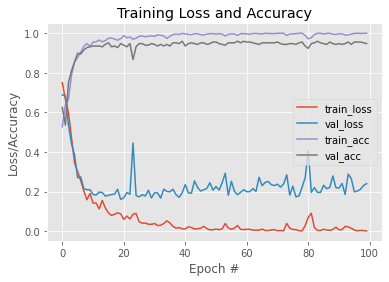

In [ ]:
# plot the training loss and accuracy
from matplotlib import pyplot as plt
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")